In [1]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, ScalarFormatter
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec

## Data Upload

In [294]:
# Блок загрузки и конкатенации списков всех скважин ННГ, Муравленко и МНГ
wi_nng_init = pd.read_csv('wi_nng.csv', encoding = 'cp1251', sep = ';')
wi_mur_init = pd.read_csv('wi_mur.csv', encoding = 'cp1251', sep = ';')
wi_mng_init = pd.read_csv('wi_mng.csv', encoding = 'cp1251', sep = ';')
wi_total_init = pd.concat([wi_mng_init, wi_mur_init, wi_nng_init], ignore_index=True)
wi_total_init.rename(columns = 
            {'FIELD':'oilfield',
             'UWI':'uwi_well',
             'КУСТ':'pad',
             'Х_ЗАБОЙ':'bot_x',
             'Y_ЗАБОЙ':'bot_y',
             'ТИП_СКВАЖИНЫ':'well_type',
             'ОБЪЕКТЫ_РАЗРАБОТКИ':'zone_target',
             'ИМЯ_NGT':'ngt_name',
             'СИСТЕМА_КООРДИНАТ':'coord_sys'
             }, inplace=True)
wi_total = wi_total_init[['oilfield', 'pad', 'uwi_well', 'bot_x', 'bot_y', 'well_type',
                         'zone_target', 'ngt_name', 'coord_sys']]
convert_dict = {'oilfield': 'string',
                'pad': 'string',
                'uwi_well': 'string',
                'bot_x': 'float64',
                'bot_y': 'float64',
                'well_type': 'string',
                'zone_target': 'string',
                'ngt_name': 'string',
                'coord_sys': 'string',
               } 
wi_total = wi_total.astype(convert_dict)

wi_total_wellnum = pd.Series([i.split('_')[1] for i in wi_total.uwi_well])
wi_total['well'] = wi_total_wellnum

wi_total['fld_well'] = pd.Series(['_'.join(i) for i in zip(wi_total.oilfield.map(str),wi_total.well)], name='fld_well')

# Выборка разведок по 43 и 44 зоне зоне
wi_total43 = wi_total.query('coord_sys == "UTM-43"')
wi_total44 = wi_total.query('coord_sys == "UTM-44"')
# Чистка разведок по 43 зоне по координатам Y
wi_total43 = wi_total43.query('bot_y > 6.e+06')

In [295]:
# В связи с тем что из ГеоБД невозможно выгрузить испытания по списку всех скважин Муравленко (база падает по out of memory), 
# пришлось сделать выборку только разведочных скважин.
wi_mur_init = pd.read_csv('wi_mur.csv', encoding = 'cp1251', sep = ';')
wi_mur_init.rename(columns = 
            {'FIELD':'oilfield',
             'UWI':'uwi_well',
             'КУСТ':'pad',
             'Х_ЗАБОЙ':'bot_x',
             'Y_ЗАБОЙ':'bot_y',
             'ТИП_СКВАЖИНЫ':'well_type',
             'ОБЪЕКТЫ_РАЗРАБОТКИ':'zone_target',
             'ИМЯ_NGT':'ngt_name',
             'СИСТЕМА_КООРДИНАТ':'coord_sys'
             }, inplace=True)
wi_mur = wi_mur_init[['oilfield', 'pad', 'uwi_well', 'bot_x', 'bot_y', 'well_type',
                         'zone_target', 'ngt_name', 'coord_sys']]
convert_dict = {'oilfield': 'string',
                'pad': 'string',
                'uwi_well': 'string',
                'bot_x': 'float64',
                'bot_y': 'float64',
                'well_type': 'string',
                'zone_target': 'string',
                'ngt_name': 'string',
                'coord_sys': 'string',
               } 
wi_mur = wi_mur.astype(convert_dict)
well_type_list = ['Поисковая скважина', 'Разведочная скважина', 'Поисково оценочная скважина','Параметрическая скважина','Поисково-оценочная']
wi_mur_expl = wi_mur[wi_mur.well_type.isin(well_type_list)]
wi_mur_expl.uwi_well.to_csv('mur_wlist_expl.csv', index=False)

In [154]:
# Выгрузка номеров скважин для выгрузки испытаний
# wi_mur_init['UWI'].to_csv('mur_wlist.csv',index=False)
# wi_nng_init['UWI'].to_csv('nng_wlist.csv',index=False)
# wi_mng_init['UWI'].to_csv('mng_wlist.csv',index=False)

In [837]:
# Загрузка результатов испытаний по ННГ и Муравленко, конкатенация и выборка только скважин с нефтью
wt_mur_init = pd.read_csv('wt_mur.csv', encoding = 'cp1251', sep = ';')
wt_nng_init = pd.read_csv('wt_nng.csv', encoding = 'cp1251', sep = ';')
wt_total_init = pd.concat([wt_mur_init, wt_nng_init], ignore_index=True)
wt_total_init.rename(columns = 
            {'СКВАЖИНА':'well',
             'ПЛАСТ':'zone',
             'ВЕРХ_ИСП':'top_dst',
             'НИЗ_ИСП':'bot_dst',
             'МЕСТОРОЖДЕНИЕ':'oilfield',
             'КОММЕНТАРИЙ':'comments',
             'QН':'oil',
             'QГ':'gas',
             'QВ':'water',
             'QЖ':'liquid',
             'DШТ':'D'
             }, inplace=True)
wt_total = wt_total_init[['oilfield', 'well', 'zone', 'top_dst', 'bot_dst', 'oil',
                         'gas', 'water', 'liquid', 'D', 'comments']]
wt_total = wt_total.fillna(0)
wt_total = wt_total.convert_dtypes()
wt_total['fld_well'] = pd.Series(['_'.join(i) for i in zip(wt_total.oilfield.map(str),wt_total.well)], name='fld_well')
wt_total = wt_total.query('oil != " "')
wt_total['zone'] = wt_total['zone'].astype('string')
wt_total['oil'] = wt_total['oil'].astype('float64')
wt_total['gas'] = wt_total['gas'].astype('float64')
wt_total['water'] = wt_total['water'].astype('float64')
wt_total['liquid'] = wt_total['liquid'].astype('float64')
wt_total_oil = wt_total.query('oil >= 5')

In [834]:
wt_total_water = wt_total.query('oil <5 and water != 0')

In [835]:
# Выборка развелочных скважин из всего списка НММ для 43 зоны
well_type_list = ['Поисковая скважина', 'Разведочная скважина', 'Поисково оценочная скважина','Параметрическая скважина','Поисково-оценочная']
wi_total43_expl = wi_total43[wi_total43.well_type.isin(well_type_list)]
wi_total43_prod = wi_total43[~wi_total43.well_type.isin(well_type_list)]

In [838]:
# Ключевой момент - джойним разведки с испытаниями с нефтью и координаты скважин из well_info
wi_total43_coord = wi_total43[['fld_well', 'bot_x', 'bot_y','zone_target','ngt_name']]
wi_total43_coord = wi_total43_coord.set_index('fld_well')
wt_total_oil = wt_total_oil.set_index('fld_well')
wt_total_oil43 = wt_total_oil.join(wi_total43_coord)
wt_total_oil43 = wt_total_oil43.reset_index()

In [481]:
# Ключевой момент - джойним разведки с испытаниями с водой и координаты скважин из well_info
wt_total_water = wt_total_water.set_index('fld_well')
wt_total_wat43 = wt_total_water.join(wi_total43_coord)
wt_total_wat43 = wt_total_wat43.reset_index()

In [333]:
# Получение средних координат по месторождения
field_names = wi_total43.groupby(['oilfield']).mean()
field_names = pd.DataFrame(field_names[~field_names.index.str.contains('УЧАСТОК')])
field_names = field_names.reset_index()
field_names['oilfield']=field_names.oilfield.astype('string')

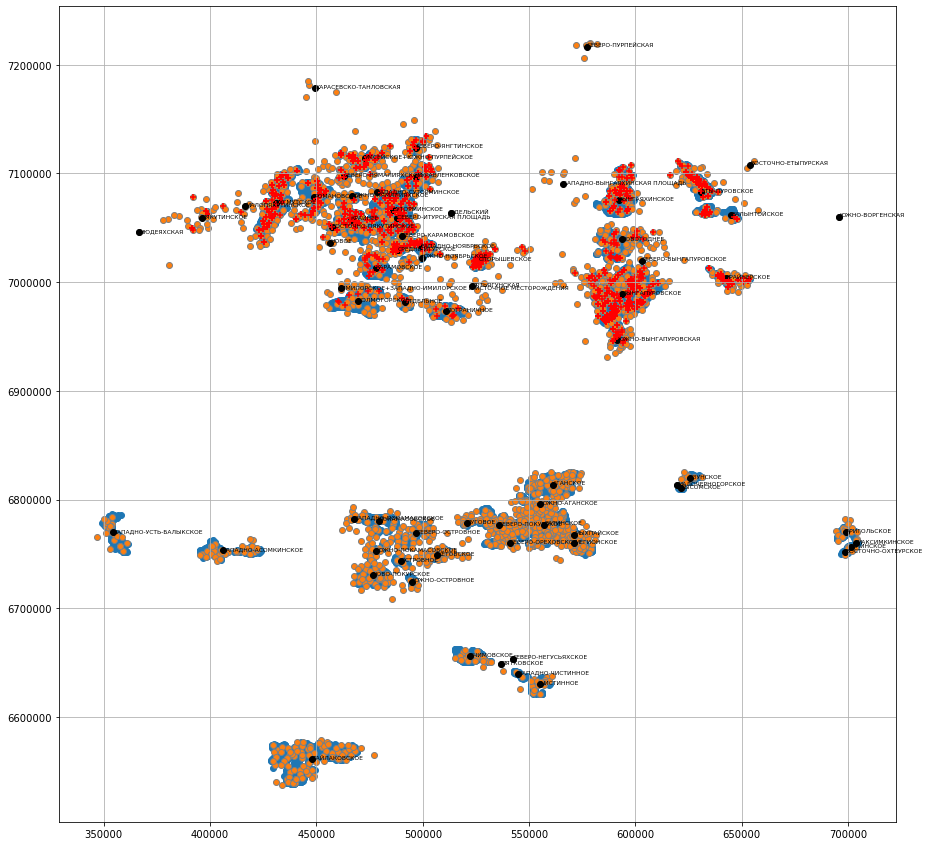

In [334]:
# Общая карта по всем месторождениям
f, ax = plt.subplots(figsize=(15,15))
x = wi_total43_prod.bot_x
y = wi_total43_prod.bot_y
x_expl = wi_total43_expl.bot_x
y_expl = wi_total43_expl.bot_y
x_agg = agg_field_names.bot_x
y_agg = agg_field_names.bot_y
text = agg_field_names.oilfield
x_wt = wt_total_oil43.bot_x
y_wt = wt_total_oil43.bot_y
for i, txt in enumerate(field_names.oilfield):
    ax.annotate(txt, (field_names.bot_x.iloc[i], field_names.bot_y.iloc[i]), fontsize = 6)
ax.scatter(x, y)
ax.scatter(x_expl, y_expl, edgecolors ='gray')
ax.scatter(x_agg, y_agg, c='black')
ax.scatter(x_wt, y_wt, c='red', marker = '+')
sf = ScalarFormatter()
sf.set_powerlimits((-7, 7))
ax.yaxis.set_major_formatter(sf)
ax.grid()

In [506]:
x_min_field_vyng = 550000
x_max_field_vyng = 655000
y_min_field_vyng = 6925000
y_max_field_vyng = 7120000

In [516]:
field_names_sel_vyng = field_names[field_names.bot_x.between(x_min_field_vyng, x_max_field_vyng) & field_names.bot_y.between(y_min_field_vyng, y_max_field_vyng)]
well_names_sel_vyng = wt_total_oil43[wt_total_oil43.bot_x.between(x_min_field_vyng, x_max_field_vyng) & wt_total_oil43.bot_y.between(y_min_field_vyng, y_max_field_vyng)]
well_names_sel_wat_vyng = wt_total_wat43[wt_total_wat43.bot_x.between(x_min_field_vyng, x_max_field_vyng) & wt_total_wat43.bot_y.between(y_min_field_vyng, y_max_field_vyng)]

Wall time: 106 ms


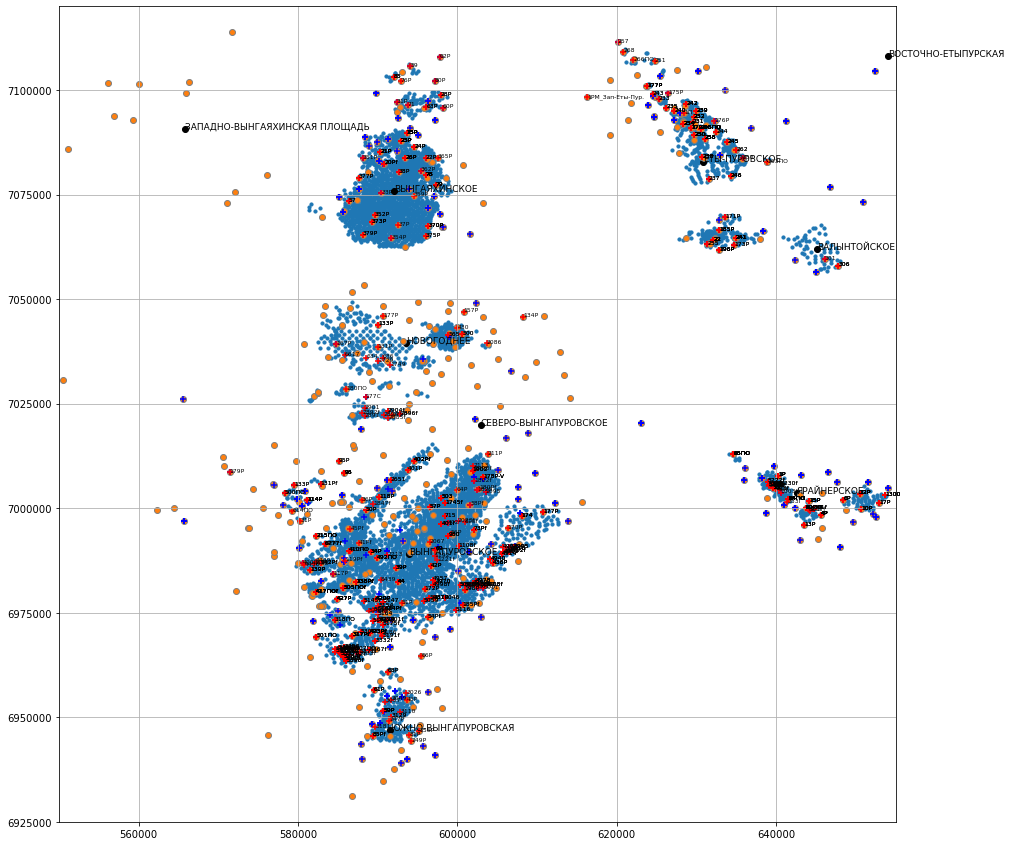

In [526]:
%%time
f, ax = plt.subplots(figsize=(15,15))

x = wi_total43_prod.bot_x
y = wi_total43_prod.bot_y
x_expl = wi_total43_expl.bot_x
y_expl = wi_total43_expl.bot_y
x_agg = field_names.bot_x
y_agg = field_names.bot_y
txt_field = field_names.oilfield
x_wt = well_names_sel.bot_x
y_wt = well_names_sel.bot_y
x_wt_w = well_names_sel_wat_vyng.bot_x
y_wt_w = well_names_sel_wat_vyng.bot_y
text_wt = well_names_sel.ngt_name
for i, txt_field in enumerate(field_names_sel_vyng.oilfield):
    ax.annotate(txt_field, (field_names_sel_vyng.bot_x.iloc[i], field_names_sel_vyng.bot_y.iloc[i]), fontsize = 9)
for j, text_wt in enumerate(well_names_sel_vyng.ngt_name):
    ax.annotate(text_wt, (well_names_sel_vyng.bot_x.iloc[j], well_names_sel_vyng.bot_y.iloc[j]), fontsize = 6)
    
ax.scatter(x, y, s=10)
ax.scatter(x_agg, y_agg, c='black')
ax.scatter(x_expl, y_expl, edgecolors ='gray')
ax.scatter(x_wt_w, y_wt_w, c='blue', marker = '+')
ax.scatter(x_wt, y_wt, c='red', marker = '+')

sf = ScalarFormatter()
sf.set_powerlimits((-7, 7))
ax.yaxis.set_major_formatter(sf)

ax.set_xlim(x_min_field_vyng, x_max_field_vyng)
ax.set_ylim(y_min_field_vyng, y_max_field_vyng)

ax.grid();

In [527]:
f.savefig('expl_wells43_vyng_5t_wat.pdf',bbox_inches='tight')

In [570]:
report_vyng = well_names_sel_vyng.query('ngt_name == "62P" or ngt_name == "80P" or ngt_name == "257" or ngt_name == "1PM_Зап-Еты-Пур." or ngt_name == "263ПО"'
                         'or ngt_name == "157Р" or ngt_name == "134Р" or ngt_name == "179P" or ngt_name == "95Р" or ngt_name == "96"'
                         'or ngt_name == "501ПО" or ngt_name == "66Р" or ngt_name == "13Р" or ngt_name == "6Р" or ngt_name == "61Р" or ngt_name == "249Р"')
report_vyng.to_csv('report_vyng.csv', encoding='cp1251', sep=';')
# report_vyng

In [512]:
x_min_field_spo = 375000
x_max_field_spo = 550000
y_min_field_spo = 6950000
y_max_field_spo = 7150000

In [513]:
field_names_sel_spo = field_names[field_names.bot_x.between(x_min_field_spo, x_max_field_spo) & field_names.bot_y.between(y_min_field_spo, y_max_field_spo)]
well_names_sel_spo = wt_total_oil43[wt_total_oil43.bot_x.between(x_min_field_spo, x_max_field_spo) & wt_total_oil43.bot_y.between(y_min_field_spo, y_max_field_spo)]
well_names_sel_wat_spo = wt_total_wat43[wt_total_wat43.bot_x.between(x_min_field_spo, x_max_field_spo) & wt_total_wat43.bot_y.between(y_min_field_spo, y_max_field_spo)]

Wall time: 113 ms


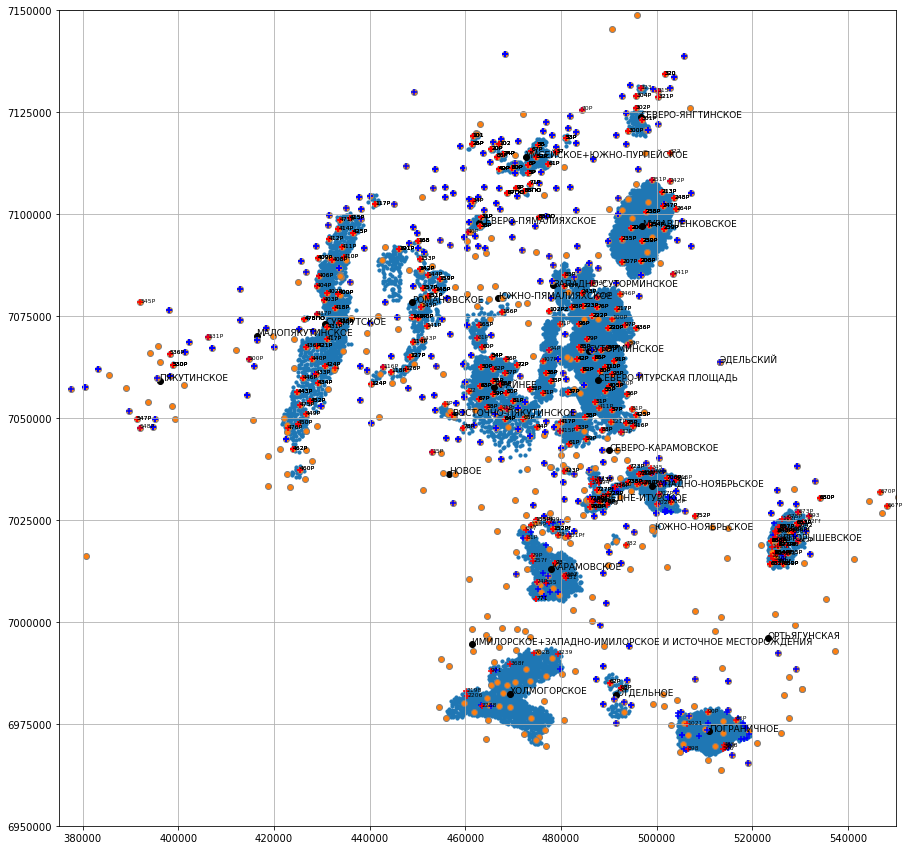

In [522]:
%%time
f, ax = plt.subplots(figsize=(15,15))
x = wi_total43_prod.bot_x
y = wi_total43_prod.bot_y
x_expl = wi_total43_expl.bot_x
y_expl = wi_total43_expl.bot_y
x_agg = field_names.bot_x
y_agg = field_names.bot_y
txt_field = field_names.oilfield
x_wt = well_names_sel_spo.bot_x
y_wt = well_names_sel_spo.bot_y
x_wt_w = well_names_sel_wat_spo.bot_x
y_wt_w = well_names_sel_wat_spo.bot_y
text_wt = well_names_sel_spo.ngt_name
for i, txt_field in enumerate(field_names_sel_spo.oilfield):
    ax.annotate(txt_field, (field_names_sel_spo.bot_x.iloc[i], field_names_sel_spo.bot_y.iloc[i]), fontsize = 9)
for j, text_wt in enumerate(well_names_sel_spo.ngt_name):
    ax.annotate(text_wt, (well_names_sel_spo.bot_x.iloc[j], well_names_sel_spo.bot_y.iloc[j]), fontsize = 6)
    
ax.scatter(x, y, s=10)
ax.scatter(x_agg, y_agg, c='black')
ax.scatter(x_expl, y_expl, edgecolors ='gray')
ax.scatter(x_wt_w, y_wt_w, c='blue', marker = '+')
ax.scatter(x_wt, y_wt, c='red', marker = '+')

sf = ScalarFormatter()
sf.set_powerlimits((-7, 7))
ax.yaxis.set_major_formatter(sf)

ax.set_xlim(x_min_field_spo, x_max_field_spo)
ax.set_ylim(y_min_field_spo, y_max_field_spo)

ax.grid();

In [523]:
f.savefig('expl_wells43_spor_5t_wat.pdf',bbox_inches='tight')

In [564]:
report_spo = well_names_sel_spo.query('ngt_name == "680Р" or ngt_name == "670Р" or ngt_name == "667Р" or ngt_name == "242P" or ngt_name == "322" or ngt_name == "241P"' 
                    'or ngt_name == "320" or ngt_name == "321P" or ngt_name == "70P" or ngt_name == "87ПО" or ngt_name == "85ПО"')
# report_spo.to_csv('report_spo.csv', encoding='cp1251', sep=';')

## Data Processing

In [846]:
# Формирование краткого списка без дубликатов с разведками
wt_total_oil43_dropna = wt_total_oil43.dropna(subset=(['bot_x', 'bot_y']))
wt_total_oil43_dropna = wt_total_oil43_dropna[['fld_well', 'bot_x','bot_y']]
wt_total_oil43_dropna.drop_duplicates(inplace=True)

In [981]:
%%time
# Расчет рассстояний между разведками и соседними скважинами по wt_total_oil43_dropna
global_name = []
global_dist = []
for j, exp in enumerate(wt_total_oil43_dropna.fld_well[:]):
#     j=15
    name = []
    dist = []
#     print(j, exp, wt_total_oil43_dropna.bot_x.iloc[j], wt_total_oil43_dropna.bot_x.iloc[j])
#     print('*****')
    for i, well in enumerate(wi_total43_prod.fld_well[:]):
        dist_calc_x2 = (wi_total43_prod.bot_x.iloc[i] - wt_total_oil43_dropna.bot_x.iloc[j])**2
        dist_calc_y2 = (wi_total43_prod.bot_y.iloc[i] - wt_total_oil43_dropna.bot_y.iloc[j])**2
        dist_calc = (dist_calc_x2 + dist_calc_y2)**(1/2)
        name.append(exp + ':' + well)
        dist.append((dist_calc/1000))
#         print(j, exp, wt_total_oil43_dropna.bot_x.iloc[j], wt_total_oil43_dropna.bot_y.iloc[j], i, well, wi_total43_prod.bot_x.iloc[i], wi_total43_prod.bot_y.iloc[i],(dist_calc/1000) )
#         print(i, well, round(dist_calc/1000))
    dict_dist = dict(zip(dist,name))
    dict_min = min(dict_dist.keys())
#     print(dict_dist[dict_min], dict_min)
    global_name.append(dict_dist[dict_min])
    global_dist.append(dict_min)
# print(global_name, global_dist)

Wall time: 13min 8s


In [993]:
# Отчетность по расстояниям между скважинами
report_dist = pd.DataFrame.from_records((zip(global_dist,global_name)), columns=['dist', 'expl_well'])
report_dist[['expl', 'prod']] = report_dist.expl_well.str.split(':', expand=True)
report_dist = report_dist[['dist', 'prod', 'expl']]
report_dist[['field', 'well_exp']] = report_dist.expl.str.split('_', expand=True)
# Генерируем список скважин с расстоянием между разв и прод более 2км
report_dist = report_dist.query('dist >2')
# report_dist = report_dist.set_index('prod')
# report_dist = report_dist.join(wi_total43_coord)
# report_dist = report_dist.reset_index()
# report_dist.rename(columns = 
#             {'bot_x':'bot_x_prod',
#              'bot_y':'bot_y_prod',
#              'index':'prod'
#              }, inplace=True)
# report_dist.to_csv('reports\\report_distance.csv', encoding='cp1251', sep=';')

In [994]:
wi_total43_coord = wi_total43_coord[['bot_x', 'bot_y']]

In [995]:
report_dist = report_dist.set_index('expl')
report_dist = report_dist.join(wi_total43_coord)
report_dist.rename(columns = 
            {'bot_x':'bot_x_expl',
             'bot_y':'bot_y_expl'
             }, inplace=True)
report_dist = report_dist.reset_index()
report_dist = report_dist[['dist','prod','expl','field','well_exp','bot_x_expl','bot_y_expl']]

In [1003]:
# Финальный отчет с расстояниями больше 2км до ближайшей скважины
report_dist
# report_dist.to_csv('reports\\report_distance.csv', encoding='cp1251', sep=';')

,dist,prod,expl,field,well_exp,bot_x_expl,bot_y_expl
0,8.597542,ВЫНГАПУРОВСКОЕ_202G2,ВЫНГАПУРОВСКИЙ УЧАСТОК_179R,ВЫНГАПУРОВСКИЙ УЧАСТОК,179R,571442.8200,7008723.450
1,4.603622,ВЫНГАПУРОВСКОЕ_3308,ВЫНГАПУРОВСКОЕ_66R,ВЫНГАПУРОВСКОЕ,66R,595451.0400,6964717.280
2,5.155488,ВЫНГАПУРОВСКОЕ_302,ВЫНГАПУРОВСКОЕ_95R,ВЫНГАПУРОВСКОЕ,95R,585087.3200,7011217.670
3,3.240540,ВЫНГАПУРОВСКОЕ_302,ВЫНГАПУРОВСКОЕ_96R,ВЫНГАПУРОВСКОЕ,96R,585808.4600,7008349.560
4,4.253226,ВЫНГАЯХИНСКОЕ_2702G,ВЫНГАЯХИНСКОЕ_62R,ВЫНГАЯХИНСКОЕ,62R,597787.1600,7107898.000
5,2.506221,ВЫНГАЯХИНСКОЕ_191G,ВЫНГАЯХИНСКОЕ_80R,ВЫНГАЯХИНСКОЕ,80R,597185.8800,7102071.540
6,7.768771,ЕТЫ-ПУРОВСКОЕ_3035,ЕТЫ-ПУРОВСКОЕ_1PM,ЕТЫ-ПУРОВСКОЕ,1PM,616246.5800,7098255.830
7,3.798812,ЗАПАДНО-НОЯБРЬСКОЕ_1006,ЗАПАДНО-НОЯБРЬСКОЕ_752R,ЗАПАДНО-НОЯБРЬСКОЕ,752R,508092.7600,7025993.700
8,10.235552,СУГМУТСКОЕ_2422PL,МАЛОПЯКУТИНСКОЕ_500P,МАЛОПЯКУТИНСКОЕ,500P,414733.9500,7064487.820
9,4.928249,МУРАВЛЕНКОВСКОЕ_89,МУРАВЛЕНКОВСКОЕ_241R,МУРАВЛЕНКОВСКОЕ,241R,503489.1400,7085436.250


In [997]:
# report_dist_check = report_dist[['prod', 'expl','dist','bot_x_prod','bot_y_prod','bot_x_expl','bot_y_expl']]
# report_dist_check = report_dist_check.query('dist != 0')
# report_dist_check['x2'] = (report_dist_check.bot_x_prod - report_dist_check.bot_x_expl)**2
# report_dist_check['y2'] = (report_dist_check.bot_y_prod - report_dist_check.bot_y_expl)**2
# report_dist_check['dist_check'] = round(((report_dist_check.x2+report_dist_check.y2)**(1/2))/1000,1)
# report_dist_check
# report_dist_check[report_dist_check.expl.str.contains('ВЫНГАПУРОВСКОЕ')]

In [790]:
# Отчетность по количеству скважин на месторождении
report_dist_field_cumul = report_dist.groupby('field').count()
report_dist_field_cumul =pd.DataFrame(report_dist_field_cumul['dist'])
report_dist_field_cumul.sort_values('dist', ascending=False)
report_dist_field_cumul.to_csv('reports\\report_cumul.csv', encoding='cp1251', sep=';')

In [1009]:
wt_total_oil43_join = wt_total_oil43.set_index('fld_well')
wt_total_oil43_join.head()

,oilfield,well,zone,top_dst,bot_dst,oil,gas,water,liquid,D,comments,bot_x,bot_y,zone_target,ngt_name
fld_well,,,,,,,,,,,,,,,
ВАЛЫНТОЙСКОЕ_301PO,ВАЛЫНТОЙСКОЕ,301PO,Ю1-1,3276.0,3281.0,20.0,4.5,0.0,0.0,6,Акт от 27.04.2008,646116.90,7059644.20,,301
ВАЛЫНТОЙСКОЕ_306PO,ВАЛЫНТОЙСКОЕ,306PO,"Георг,Ю1-1",3444.5,3450.0,9.0,5.9,0.0,0.0,4,Акт от 11.11.2013,647778.44,7058029.96,Ю1,306
ВАЛЫНТОЙСКОЕ_306PO,ВАЛЫНТОЙСКОЕ,306PO,"Ю1-1,Ю1-2",3463.0,3466.0,12.9,13.9,0.0,0.0,6,Акт от 30.10.2013,647778.44,7058029.96,Ю1,306
ВАЛЫНТОЙСКОЕ_306PO,ВАЛЫНТОЙСКОЕ,306PO,Ю1-2,3472.0,3474.0,12.9,13.9,0.0,0.0,6,Акт от 30.10.2013,647778.44,7058029.96,Ю1,306
ВОРГЕНСКОЕ_772PO,ВОРГЕНСКОЕ,772PO,ЯН1,2621.0,2624.0,132.0,35.4,33.0,0.0,8,Получен приток нефти с пластовой водой и газом...,NaN,NaN,<NA>,<NA>


In [1018]:
report_dist_join = report_dist.set_index('expl')
report_dist_join.head()
final_list = wt_total_oil43_join.join(report_dist_join) 
final_list = final_list.dropna(subset=(['dist']))
final_list = final_list.reset_index()
final_list.to_csv('reports\\report_final_list.csv', encoding='cp1251', sep=';')

## Final Result

In [808]:
# Генерация информации по отборным скважинам
well_list = ['170R', '177R', '174R', '133R', '31R', '400PO', '436R', '427R', '139R', '417PO', '45R', '96R', '211R', '422R']
field_list = ['ВЫНГАПУРОВСКОЕ']
rep_vyng_list = wt_total[wt_total.oilfield.isin(field_list) & wt_total.well.isin(well_list)]
rep_vyng_list.query('oil > 1')
rep_vyng_list.drop_duplicates(inplace=True)
rep_vyng_list
# rep_vyng_list.to_csv('reports\\vyng_sel_explor.csv', encoding='cp1251', sep=';')

,oilfield,well,zone,top_dst,bot_dst,oil,gas,water,liquid,D,comments,fld_well
4486,ВЫНГАПУРОВСКОЕ,31R,"Георг,ЮВ1-1",2870.0,2880.0,52.7,0.0,0.0,0.0,8,Безводная нефть,ВЫНГАПУРОВСКОЕ_31R
4571,ВЫНГАПУРОВСКОЕ,45R,BV8-1-1,2630.0,2640.0,1.3,0.0,0.0,0.0,0,0,ВЫНГАПУРОВСКОЕ_45R
4573,ВЫНГАПУРОВСКОЕ,45R,ЮВ1-1,2912.0,2930.0,36.0,0.0,0.0,0.0,8,Безводная нефть,ВЫНГАПУРОВСКОЕ_45R
5035,ВЫНГАПУРОВСКОЕ,96R,"Ач0-2,Георг,ЮВ0,ЮВ1-1",2865.0,2957.0,15.2,0.0,0.0,0.0,0,Безводная нефть,ВЫНГАПУРОВСКОЕ_96R
5036,ВЫНГАПУРОВСКОЕ,96R,Ю2,2880.0,3050.0,15.2,0.0,0.0,0.0,0,9924,ВЫНГАПУРОВСКОЕ_96R
...,...,...,...,...,...,...,...,...,...,...,...,...
6290,ВЫНГАПУРОВСКОЕ,436R,BV8-1-10,2943.0,2956.0,0.0,0.0,3.9,0.0,0,0,ВЫНГАПУРОВСКОЕ_436R
6292,ВЫНГАПУРОВСКОЕ,436R,"БВ7-2,БВ8-1-4",2943.0,2956.0,0.0,0.0,0.0,3.9,0,Фильтрат бурового раствора,ВЫНГАПУРОВСКОЕ_436R
6293,ВЫНГАПУРОВСКОЕ,436R,BV8-1-10,2946.0,2955.0,7.0,0.0,0.0,0.0,0,0,ВЫНГАПУРОВСКОЕ_436R
6295,ВЫНГАПУРОВСКОЕ,436R,BV8-1-10,2946.0,2955.0,9.3,0.0,0.0,0.0,0,0,ВЫНГАПУРОВСКОЕ_436R
